This notebook checks statistics of epigenomics profiles output from deepTools, the results are not used in any figures in the paper. 

In [25]:
# -------------------- Standard Library Imports --------------------
import argparse
import glob
import os
import sys
from multiprocessing import Pool, cpu_count
from random import sample
from subprocess import PIPE, Popen, STDOUT, call, run
import gzip

# -------------------- Scientific Libraries ------------------------
import numpy as np
import pandas as pd
import pybedtools
import pysam
import scipy
import statsmodels.stats.multitest as smm
from Bio import SeqIO

# -------------------- Visualization Libraries ---------------------
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as clr
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from matplotlib_venn import venn2, venn2_circles

# -------------------- Matplotlib Configuration --------------------
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica Neue'

# -------------------- PyBedTools Temp Directory -------------------
pybedtools.helpers.set_tempdir('/fs/cbsuhy02/storage/jz855/tmp/') 


In [9]:
# Specify root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))


In [167]:
import gzip
import json
import pandas as pd

# Mapping from sample label (as provided in the metadata) to profile type.
profile_dict = {
    'ENCFF972GVB': 'DNase-seq', 
    'ENCFF102ARJ': 'ATAC-seq', 
    'fc_over_ctrl_ENCFF911JVK': 'H3K4me3', 
    'fc_over_ctrl_ENCFF381NDD': 'H3K27ac'
}

def process_matrix_file(data_path, call_types, dataset, offset=6):
    """
    Process a computeMatrix .gz file and return a list of DataFrames of mean signal profiles.
    
    This function does the following:
      1. Opens the .gz file in text mode and reads the first line containing metadata.
         The metadata is expected to be a JSON string prefixed by "@" and must contain:
           - "sample_boundaries": a list of bin boundaries (e.g., [0, 200, 400])
           - "group_boundaries": a list of row indices separating the groups (e.g., [0, 46906, 58585])
           - "sample_labels": (optional) a list of labels for each sample
      2. Reads the remainder of the file (the signal data) into a DataFrame.
      3. For each sample, it uses the sample boundaries (adjusted by the provided offset) to subset 
         the appropriate columns. It then splits the rows into two groups as defined by group_boundaries,
         computes the mean across rows for each group, and annotates the resulting DataFrame.
      4. The function returns a list of DataFrames (one for each sample) containing the mean profile
         for that sample with annotation columns:
            - 'profile_type': the type of signal (using profile_dict)
            - 'call_type': "Lab-reported" for group 1 and "Uniform Processed" for group 2, or "Both" for group1 and "Either" for group2
            - 'dataset': provided dataset name.
    
    Parameters:
      data_path (str): Path to the computeMatrix .gz file.
      call_types (list of str): A list specifying the call type labels for the two groups 
                                (e.g., ["Lab-reported", "Uniform Processed"]).dataset (str): Name of the dataset (used for annotation).
      offset (int): Number of non-signal columns at the beginning of each row (default is 6).
      
    Returns:
      df_list (list of pd.DataFrame): A list of DataFrames, one per sample, each containing the mean signal profile
                                      for both groups along with annotation columns.
    """
    # Open the gz file in text mode and read the first line (metadata)
    with gzip.open(data_path, 'rt') as f:
        meta_line = f.readline().strip()
        
    # Remove any leading "@" and parse the JSON metadata.
    if meta_line.startswith("@"):
        meta_line = meta_line[1:]
    meta = json.loads(meta_line)
    
    # Extract boundaries dynamically from the metadata
    sample_boundaries = meta.get("sample_boundaries")  # e.g., [0, 200, 400]
    group_boundaries = meta.get("group_boundaries")      # e.g., [0, 46906, 58585]
    
    # Retrieve sample labels, defaulting to "sample_1", "sample_2", etc. if not provided.
    sample_labels = meta.get("sample_labels", [f"sample_{i+1}" for i in range(len(sample_boundaries)-1)])
    
    # Read the remainder of the file into a DataFrame. We skip the metadata line.
    df = pd.read_csv(data_path, sep='\t', skiprows=1, header=None)
    
    # List to store mean profile DataFrames for each sample.
    df_list = []
    
    # For each sample, determine the columns corresponding to that sample based on sample_boundaries.
    for idx in range(len(sample_labels)):
        # Compute starting and ending column indices for the sample.
        col_start = offset + sample_boundaries[idx]
        col_end = offset + sample_boundaries[idx+1]
        
        # Subset rows for group 1 (Lab-reported). Rows range from group_boundaries[0] to group_boundaries[1]-1.
        group_1 = df.loc[group_boundaries[0]:group_boundaries[1]-1, col_start:col_end-1]
        # Subset rows for group 2 (Uniform Processed). Rows range from group_boundaries[1] to group_boundaries[2]-1.
        group_2 = df.loc[group_boundaries[1]:group_boundaries[2]-1, col_start:col_end-1]
        
        # Compute the mean signal profile for group 1 across rows.
        group_1_mean = group_1.mean(axis=0).to_frame()
        # Annotate with the profile type using the sample label and the profile_dict mapping.
        group_1_mean['profile_type'] = profile_dict[sample_labels[idx]]
        group_1_mean['call_type'] = call_types[0]
        
        # Compute the mean signal profile for group 2.
        group_2_mean = group_2.mean(axis=0).to_frame()
        group_2_mean['profile_type'] = profile_dict[sample_labels[idx]]
        group_2_mean['call_type'] = call_types[1]
        
        # Concatenate the two groups vertically.
        sample_mean_df = pd.concat([group_1_mean, group_2_mean], axis=0, ignore_index=True)
        sample_mean_df['dataset'] = dataset
        
        # Append this DataFrame to the list.
        df_list.append(sample_mean_df)
        
    return df_list


In [133]:
def boxplot(data,
            x_col,
            y_col,
            hue_col,
            hue_order,
            x_order,
            xlabel,
            ylabel,
            x_tick_labels,
            out_path='',
            rotation=30):
    """
    Create and optionally save a boxplot using Seaborn.

    Parameters:
      data (pd.DataFrame): The input DataFrame containing the data to plot.
      x_col (str): The name of the column to use on the x-axis.
      y_col (str): The name of the column to use on the y-axis.
      hue_col (str): The name of the column to use for color encoding (hue).
      hue_order (list): The order of categories for the hue.
      x_order (list): The order of categories for the x-axis.
      xlabel (str): Label for the x-axis.
      ylabel (str): Label for the y-axis.
      x_tick_labels (list): List of labels to display on the x-axis ticks.
      out_path (str): Optional output file path to save the figure.
      rotation (int): Rotation angle for the x-tick labels.

    Returns:
      None. The function creates a boxplot and saves the figure if an output path is provided.
    """
    
    # Create a new figure with a specified size.
    fig = plt.figure(figsize=(5, 4))
    
    # Create the boxplot using Seaborn.
    # - 'data' is the input DataFrame.
    # - 'x_col' and 'y_col' specify which columns to use for the x and y axes.
    # - 'hue_col' is used to further divide the data into categories with specified colors.
    # - 'order' and 'hue_order' control the order of the x-axis and hue categories, respectively.
    # - 'palette' is assumed to be defined externally; it specifies colors for the categories.
    # - 'fill=False' creates unfilled (outlined) boxes.
    # - 'width' sets the width of each box, and 'gap' controls spacing.
    ax = sns.boxplot(data=data, 
                     x=x_col, 
                     y=y_col, 
                     hue=hue_col,
                     hue_order=hue_order, 
                     order=x_order, 
                     palette=palette, 
                     fill=False, 
                     width=0.5, 
                     gap=0.2)
    
    # Set the x-axis and y-axis labels with a larger font size.
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)

    # Set custom x-tick labels, applying the given rotation and font size.
    ax.set_xticklabels(x_tick_labels, rotation=rotation, fontsize=17)

    # Retrieve current y-tick values and format them as rounded strings.
    y_ticks = ax.get_yticks().tolist()
    # y_tick_labels = [f"{round(tick)}" for tick in y_ticks]
    ax.set_yticklabels(y_ticks, fontsize=17)

    # Remove the top and right spines (borders) for a cleaner look.
    sns.despine()
    
    # Configure the legend with custom settings and position it outside the plot.
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        fancybox=True,
        ncol=1,
        borderaxespad=0.,
        fontsize=15
    )

    # If an output path is specified, save the figure as a file.
    if out_path != '':
        plt.savefig(out_path, bbox_inches='tight', transparent=True, dpi=300)
        

# lab-reported call (original) vs. uniform processed

## DNase-seq & ATAC-seq

In [134]:
# DNase-seq & ATAC-seq
open_region_root = os.path.join(project_root, 'data', 'output', 'computeMatrix', 
                                'original_vs_processed', 'matrix_DNase_ATAC')


In [135]:
# DNase-seq and ATAC-seq mean profile computation for multiple datasets.
# The function `process_matrix_file` reads a computeMatrix .gz file, parses its metadata to obtain
# sample boundaries (e.g., [0, 200, 400]) and group boundaries, and then computes the mean signal profiles
# for two groups (e.g., Lab-reported and Uniform Processed). It returns two DataFrames:
#   - One for DNase-seq (sample 1)
#   - One for ATAC-seq (sample 2)
# The 'offset' parameter indicates the number of non-signal columns at the start of each row.

# ------------------------------
# Process TilingMPRA dataset
# ------------------------------
# Build the data file path for TilingMPRA using the open_region_root directory.
data_path = os.path.join(open_region_root, 'tilingmpra.gz')
# Specify the dataset name.
dataset = 'TilingMPRA'
# Call process_matrix_file to extract mean profiles.
# The function returns two DataFrames: one for DNase-seq and one for ATAC-seq.
tilingmpra_dnase_seq, tilingmpra_atac_seq = process_matrix_file(data_path, ['Lab-reported', 'Uniform Processed'], dataset, offset=6)

# ------------------------------
# Process LentiMPRA dataset
# ------------------------------
# Build the data file path for LentiMPRA.
data_path = os.path.join(open_region_root, 'lentimpra.gz')
# Set the dataset name.
dataset = 'LentiMPRA'
# Extract the DNase-seq and ATAC-seq mean profiles.
lentimpra_dnase_seq, lentimpra_atac_seq = process_matrix_file(data_path, ['Lab-reported', 'Uniform Processed'], dataset, offset=6)

# ------------------------------
# Process ATAC-STARR-seq dataset
# ------------------------------
# Build the data file path for ATAC-STARR-seq.
data_path = os.path.join(open_region_root, 'atac_starr.gz')
# Set the dataset name.
dataset = 'ATAC-STARR-seq'
# Extract the DNase-seq and ATAC-seq mean profiles.
atac_starr_dnase_seq, atac_starr_atac_seq = process_matrix_file(data_path, ['Lab-reported', 'Uniform Processed'], dataset, offset=6)

# ------------------------------
# Process WHG-STARR-seq dataset
# ------------------------------
# Build the data file path for WHG-STARR-seq.
data_path = os.path.join(open_region_root, 'whg_starr.gz')
# Set the dataset name.
dataset = 'WHG-STARR-seq'
# Extract the DNase-seq and ATAC-seq mean profiles.
whg_starr_dnase_seq, whg_starr_atac_seq = process_matrix_file(data_path, ['Lab-reported', 'Uniform Processed'], dataset, offset=6)


<ipython-input-84-e64b57c15db3>:63: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t', skiprows=1, header=None)
<ipython-input-84-e64b57c15db3>:63: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t', skiprows=1, header=None)


In [136]:
# Paired comparisons between lab-reported and uniform processed calls.
# For each DataFrame (representing a profile for a specific dataset and signal type),
# we perform a Mann-Whitney U test comparing the signal values between the two groups:
#  - "Lab-reported" (original calls)
#  - "Uniform Processed" (processed calls)
#
# We assume that the data column containing the mean signal profiles is column 0.
# The 'alternative' parameter is set to 'less', testing whether the values in the lab-reported group
# are statistically lower than those in the uniform processed group.

for data in [tilingmpra_dnase_seq, lentimpra_dnase_seq, atac_starr_dnase_seq, whg_starr_dnase_seq]:
    # Separate the data into two groups based on the 'call_type' column.
    lab_reported = data[data['call_type'] == 'Lab-reported']
    uniform_processed = data[data['call_type'] == 'Uniform Processed']
    
    # Retrieve the dataset name from the 'dataset' column (assumes all rows have the same dataset value).
    dataset = data['dataset'].tolist()[0]
    print("Dataset:", dataset)
    
    # Retrieve the profile type (e.g., DNase-seq) from the 'profile_type' column.
    profile_type = data['profile_type'].tolist()[0]
    print("Profile type:", profile_type)
    
    # Perform the Mann-Whitney U test on the mean signal values.
    # We assume that the signal values are stored in column 0 of the DataFrame.
    test_statistic, p_value = scipy.stats.mannwhitneyu(
        lab_reported[0].values, 
        uniform_processed[0].values, 
        alternative='less'
    )
    print("Mann-Whitney U test result (statistic, p-value):", test_statistic, p_value)
    print('-----')
    

Dataset: TilingMPRA
Profile type: DNase-seq
Mann-Whitney U test result (statistic, p-value): 2749.0 1.2080421451798496e-50
-----
Dataset: LentiMPRA
Profile type: DNase-seq
Mann-Whitney U test result (statistic, p-value): 14613.0 1.588547769396821e-06
-----
Dataset: ATAC-STARR-seq
Profile type: DNase-seq
Mann-Whitney U test result (statistic, p-value): 14862.0 4.422181424671928e-06
-----
Dataset: WHG-STARR-seq
Profile type: DNase-seq
Mann-Whitney U test result (statistic, p-value): 11716.0 3.895832797856541e-13
-----


<ipython-input-133-bee54acd818d>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=rotation, fontsize=17)
<ipython-input-133-bee54acd818d>:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks, fontsize=17)


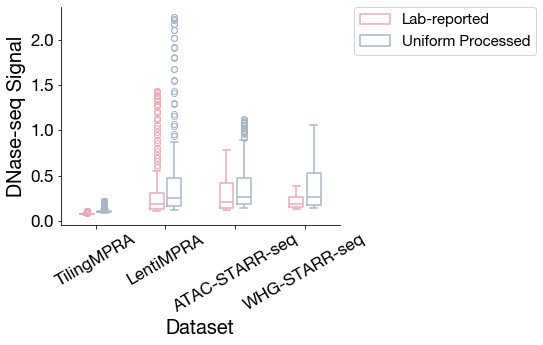

In [137]:
# DNase-seq 
plot_df = pd.concat([tilingmpra_dnase_seq, lentimpra_dnase_seq, atac_starr_dnase_seq, whg_starr_dnase_seq], ignore_index=True, axis=0)
plot_df.columns = ['signal', 'profile_type', 'call_type', 'dataset']

boxplot(data=plot_df,
    x_col='dataset',
    y_col='signal',
    hue_col='call_type',
    hue_order=['Lab-reported', 'Uniform Processed'],
    x_order=['TilingMPRA', 'LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq'],
    xlabel='Dataset',
    ylabel='DNase-seq Signal',
    x_tick_labels=['TilingMPRA', 'LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq'],
    out_path='',
    rotation=30)


In [138]:
# Paired comparisons between lab-reported and uniform processed calls.
# For each DataFrame (representing a profile for a specific dataset and signal type),
# we perform a Mann-Whitney U test comparing the signal values between the two groups:
#  - "Lab-reported" (original calls)
#  - "Uniform Processed" (processed calls)
#
# We assume that the data column containing the mean signal profiles is column 0.
# The 'alternative' parameter is set to 'less', testing whether the values in the lab-reported group
# are statistically lower than those in the uniform processed group.

for data in [tilingmpra_atac_seq, lentimpra_atac_seq, atac_starr_atac_seq, whg_starr_atac_seq]:
    # Separate the data into two groups based on the 'call_type' column.
    lab_reported = data[data['call_type'] == 'Lab-reported']
    uniform_processed = data[data['call_type'] == 'Uniform Processed']
    
    # Retrieve the dataset name from the 'dataset' column (assumes all rows have the same dataset value).
    dataset = data['dataset'].tolist()[0]
    print("Dataset:", dataset)
    
    # Retrieve the profile type (e.g., DNase-seq) from the 'profile_type' column.
    profile_type = data['profile_type'].tolist()[0]
    print("Profile type:", profile_type)
    
    # Perform the Mann-Whitney U test on the mean signal values.
    # We assume that the signal values are stored in column 0 of the DataFrame.
    test_statistic, p_value = scipy.stats.mannwhitneyu(
        lab_reported[0].values, 
        uniform_processed[0].values, 
        alternative='less'
    )
    print("Mann-Whitney U test result (statistic, p-value):", test_statistic, p_value)
    print('-----')
    

Dataset: TilingMPRA
Profile type: ATAC-seq
Mann-Whitney U test result (statistic, p-value): 3935.0 3.400575013461558e-44
-----
Dataset: LentiMPRA
Profile type: ATAC-seq
Mann-Whitney U test result (statistic, p-value): 17038.0 0.005210547310066756
-----
Dataset: ATAC-STARR-seq
Profile type: ATAC-seq
Mann-Whitney U test result (statistic, p-value): 16385.0 0.0008849739133617897
-----
Dataset: WHG-STARR-seq
Profile type: ATAC-seq
Mann-Whitney U test result (statistic, p-value): 12468.0 3.650680307153855e-11
-----


<ipython-input-133-bee54acd818d>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=rotation, fontsize=17)
<ipython-input-133-bee54acd818d>:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks, fontsize=17)


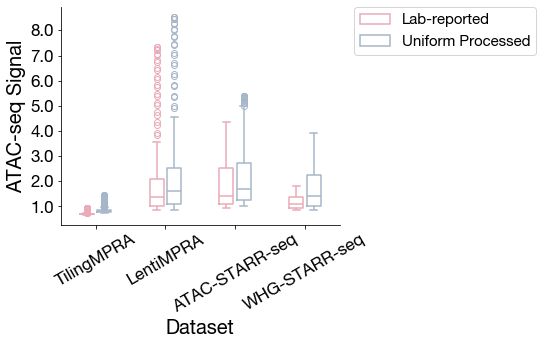

In [139]:
# ATAC-seq
plot_df = pd.concat([tilingmpra_atac_seq, lentimpra_atac_seq, atac_starr_atac_seq, whg_starr_atac_seq], ignore_index=True, axis=0)
plot_df.columns = ['signal', 'profile_type', 'call_type', 'dataset']

boxplot(data=plot_df,
    x_col='dataset',
    y_col='signal',
    hue_col='call_type',
    hue_order=['Lab-reported', 'Uniform Processed'],
    x_order=['TilingMPRA', 'LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq'],
    xlabel='Dataset',
    ylabel='ATAC-seq Signal',
    x_tick_labels=['TilingMPRA', 'LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq'],
    out_path='',
    rotation=30)


## Histone

In [140]:

# Histone: H3K4me3, H3K27ac
histone_root = os.path.join(project_root, 'data', 'output', 'computeMatrix', 
                                'original_vs_processed', 'matrix_Histone')


In [141]:
# Histone mean profile computation for multiple datasets.
# The function `process_matrix_file` reads a computeMatrix .gz file, parses its metadata to obtain
# sample boundaries (e.g., [0, 200, 400]) and group boundaries, and then computes the mean signal profiles
# for two groups (e.g., Lab-reported and Uniform Processed). It returns two DataFrames:
#   - One for H3K4me3 (sample 1)
#   - One for H3K27ac (sample 2)
# The 'offset' parameter indicates the number of non-signal columns at the start of each row.

# ------------------------------
# Process TilingMPRA dataset
# ------------------------------
# Build the data file path for TilingMPRA using the open_region_root directory.
data_path = os.path.join(histone_root, 'tilingmpra.gz')
# Specify the dataset name.
dataset = 'TilingMPRA'
# Call process_matrix_file to extract mean profiles.
# The function returns two DataFrames: one for DNase-seq and one for ATAC-seq.
tilingmpra_h3k4me3_seq, tilingmpra_h3k27ac_seq = process_matrix_file(data_path, ['Lab-reported', 'Uniform Processed'], dataset, offset=6)

# ------------------------------
# Process LentiMPRA dataset
# ------------------------------
# Build the data file path for LentiMPRA.
data_path = os.path.join(histone_root, 'lentimpra.gz')
# Set the dataset name.
dataset = 'LentiMPRA'
# Extract the DNase-seq and ATAC-seq mean profiles.
lentimpra_h3k4me3_seq, lentimpra_h3k27ac_seq = process_matrix_file(data_path, ['Lab-reported', 'Uniform Processed'], dataset, offset=6)

# ------------------------------
# Process ATAC-STARR-seq dataset
# ------------------------------
# Build the data file path for ATAC-STARR-seq.
data_path = os.path.join(histone_root, 'atac_starr.gz')
# Set the dataset name.
dataset = 'ATAC-STARR-seq'
# Extract the DNase-seq and ATAC-seq mean profiles.
atac_starr_h3k4me3_seq, atac_starr_h3k27ac_seq = process_matrix_file(data_path, ['Lab-reported', 'Uniform Processed'], dataset, offset=6)

# ------------------------------
# Process WHG-STARR-seq dataset
# ------------------------------
# Build the data file path for WHG-STARR-seq.
data_path = os.path.join(histone_root, 'whg_starr.gz')
# Set the dataset name.
dataset = 'WHG-STARR-seq'
# Extract the DNase-seq and ATAC-seq mean profiles.
whg_starr_h3k4me3_seq, whg_starr_h3k27ac_seq = process_matrix_file(data_path, ['Lab-reported', 'Uniform Processed'], dataset, offset=6)


<ipython-input-84-e64b57c15db3>:63: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t', skiprows=1, header=None)
<ipython-input-84-e64b57c15db3>:63: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t', skiprows=1, header=None)


In [143]:
# Paired comparisons between lab-reported and uniform processed calls.
# For each DataFrame (representing a profile for a specific dataset and signal type),
# we perform a Mann-Whitney U test comparing the signal values between the two groups:
#  - "Lab-reported" (original calls)
#  - "Uniform Processed" (processed calls)
#
# We assume that the data column containing the mean signal profiles is column 0.
# The 'alternative' parameter is set to 'less', testing whether the values in the lab-reported group
# are statistically lower than those in the uniform processed group.

for data in [tilingmpra_h3k4me3_seq, lentimpra_h3k4me3_seq, atac_starr_h3k4me3_seq, whg_starr_h3k4me3_seq]:
    # Separate the data into two groups based on the 'call_type' column.
    lab_reported = data[data['call_type'] == 'Lab-reported']
    uniform_processed = data[data['call_type'] == 'Uniform Processed']
    
    # Retrieve the dataset name from the 'dataset' column (assumes all rows have the same dataset value).
    dataset = data['dataset'].tolist()[0]
    print("Dataset:", dataset)
    
    # Retrieve the profile type (e.g., DNase-seq) from the 'profile_type' column.
    profile_type = data['profile_type'].tolist()[0]
    print("Profile type:", profile_type)
    
    # Perform the Mann-Whitney U test on the mean signal values.
    # We assume that the signal values are stored in column 0 of the DataFrame.
    test_statistic, p_value = scipy.stats.mannwhitneyu(
        lab_reported[0].values, 
        uniform_processed[0].values, 
        alternative='less'
    )
    print("Mann-Whitney U test result (statistic, p-value):", test_statistic, p_value)
    print('-----')
    

Dataset: TilingMPRA
Profile type: H3K4me3
Mann-Whitney U test result (statistic, p-value): 0.0 2.4154281951986995e-67
-----
Dataset: LentiMPRA
Profile type: H3K4me3
Mann-Whitney U test result (statistic, p-value): 3917.0 2.7356932021834577e-44
-----
Dataset: ATAC-STARR-seq
Profile type: H3K4me3
Mann-Whitney U test result (statistic, p-value): 8599.0 3.077715781514708e-23
-----
Dataset: WHG-STARR-seq
Profile type: H3K4me3
Mann-Whitney U test result (statistic, p-value): 0.0 2.4154281951986995e-67
-----


<ipython-input-133-bee54acd818d>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=rotation, fontsize=17)
<ipython-input-133-bee54acd818d>:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks, fontsize=17)


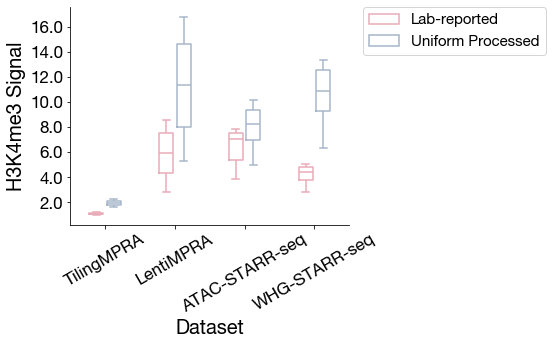

In [144]:
# H3K4me3 
plot_df = pd.concat([tilingmpra_h3k4me3_seq, lentimpra_h3k4me3_seq, atac_starr_h3k4me3_seq, whg_starr_h3k4me3_seq], ignore_index=True, axis=0)
plot_df.columns = ['signal', 'profile_type', 'call_type', 'dataset']

boxplot(data=plot_df,
    x_col='dataset',
    y_col='signal',
    hue_col='call_type',
    hue_order=['Lab-reported', 'Uniform Processed'],
    x_order=['TilingMPRA', 'LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq'],
    xlabel='Dataset',
    ylabel='H3K4me3 Signal',
    x_tick_labels=['TilingMPRA', 'LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq'],
    out_path='',
    rotation=30)


In [145]:
# Paired comparisons between lab-reported and uniform processed calls.
# For each DataFrame (representing a profile for a specific dataset and signal type),
# we perform a Mann-Whitney U test comparing the signal values between the two groups:
#  - "Lab-reported" (original calls)
#  - "Uniform Processed" (processed calls)
#
# We assume that the data column containing the mean signal profiles is column 0.
# The 'alternative' parameter is set to 'less', testing whether the values in the lab-reported group
# are statistically lower than those in the uniform processed group.

for data in [tilingmpra_h3k27ac_seq, lentimpra_h3k27ac_seq, atac_starr_h3k27ac_seq, whg_starr_h3k27ac_seq]:
    # Separate the data into two groups based on the 'call_type' column.
    lab_reported = data[data['call_type'] == 'Lab-reported']
    uniform_processed = data[data['call_type'] == 'Uniform Processed']
    
    # Retrieve the dataset name from the 'dataset' column (assumes all rows have the same dataset value).
    dataset = data['dataset'].tolist()[0]
    print("Dataset:", dataset)
    
    # Retrieve the profile type (e.g., DNase-seq) from the 'profile_type' column.
    profile_type = data['profile_type'].tolist()[0]
    print("Profile type:", profile_type)
    
    # Perform the Mann-Whitney U test on the mean signal values.
    # We assume that the signal values are stored in column 0 of the DataFrame.
    test_statistic, p_value = scipy.stats.mannwhitneyu(
        lab_reported[0].values, 
        uniform_processed[0].values, 
        alternative='less'
    )
    print("Mann-Whitney U test result (statistic, p-value):", test_statistic, p_value)
    print('-----')
    

Dataset: TilingMPRA
Profile type: H3K27ac
Mann-Whitney U test result (statistic, p-value): 0.0 2.4154281951986995e-67
-----
Dataset: LentiMPRA
Profile type: H3K27ac
Mann-Whitney U test result (statistic, p-value): 8029.0 2.0105104083728246e-25
-----
Dataset: ATAC-STARR-seq
Profile type: H3K27ac
Mann-Whitney U test result (statistic, p-value): 6478.0 6.731356938142183e-32
-----
Dataset: WHG-STARR-seq
Profile type: H3K27ac
Mann-Whitney U test result (statistic, p-value): 0.0 2.4154281951986995e-67
-----


<ipython-input-133-bee54acd818d>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=rotation, fontsize=17)
<ipython-input-133-bee54acd818d>:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks, fontsize=17)


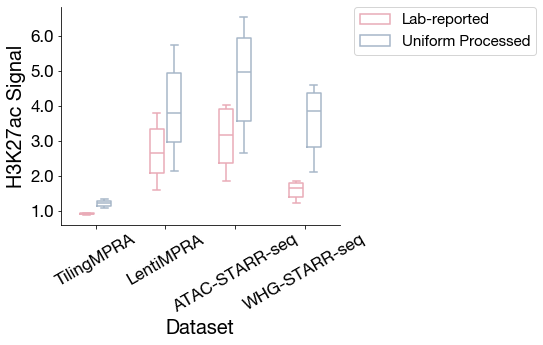

In [146]:
# ATAC-seq
plot_df = pd.concat([tilingmpra_h3k27ac_seq, lentimpra_h3k27ac_seq, atac_starr_h3k27ac_seq, whg_starr_h3k27ac_seq], ignore_index=True, axis=0)
plot_df.columns = ['signal', 'profile_type', 'call_type', 'dataset']

boxplot(data=plot_df,
    x_col='dataset',
    y_col='signal',
    hue_col='call_type',
    hue_order=['Lab-reported', 'Uniform Processed'],
    x_order=['TilingMPRA', 'LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq'],
    xlabel='Dataset',
    ylabel='H3K27ac Signal',
    x_tick_labels=['TilingMPRA', 'LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq'],
    out_path='',
    rotation=30)


# Orientation-independent calls vs. Either Orientation calls

## DNase-seq & ATAC-seq

In [168]:
# DNase-seq & ATAC-seq
open_region_root = os.path.join(project_root, 'data', 'output', 'computeMatrix', 
                                'orientation_comparison', 'matrix_DNase_ATAC')


In [175]:
data_path = os.path.join(open_region_root, 'atac_starr.gz')
# Set the dataset name.
dataset = 'ATAC-STARR-seq'


In [176]:
# Open the gz file in text mode and read the first line containing the metadata.
with gzip.open(data_path, 'rt') as f:
    meta_line = f.readline().strip()

# Remove the leading "@" if it exists, then parse the JSON metadata.
if meta_line.startswith("@"):
    meta_line = meta_line[1:]
meta = json.loads(meta_line)

# Extract dynamic boundaries from the metadata.
sample_boundaries = meta.get("sample_boundaries")  # e.g., [0, 200, 400]
group_boundaries = meta.get("group_boundaries")      # e.g., [0, 46906, 58585]

# Retrieve sample labels from the metadata, or default to "sample_1", "sample_2", etc.
sample_labels = meta.get("sample_labels", [f"sample_{i+1}" for i in range(len(sample_boundaries)-1)])

# Read the remaining signal data into a DataFrame, skipping the first metadata line.
df = pd.read_csv(data_path, sep='\t', skiprows=1, header=None)


<ipython-input-176-cb3b89638e32>:18: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t', skiprows=1, header=None)


In [177]:
meta


{'upstream': [1000, 1000],
 'downstream': [1000, 1000],
 'body': [0, 0],
 'bin size': [10, 10],
 'ref point': ['center', 'center'],
 'verbose': False,
 'bin avg type': 'mean',
 'missing data as zero': False,
 'min threshold': None,
 'max threshold': None,
 'scale': 1,
 'skip zeros': False,
 'nan after end': False,
 'proc number': 1,
 'sort regions': 'descend',
 'sort using': 'mean',
 'unscaled 5 prime': [0, 0],
 'unscaled 3 prime': [0, 0],
 'sample_labels': ['ENCFF972GVB', 'ENCFF102ARJ'],
 'group_labels': ['merged_enhancer_peak_orientation_independent.bed.gz',
  'merged_enhancer_peak_from_either_in_tested_both.bed.gz'],
 'sample_boundaries': [0, 200, 400],
 'group_boundaries': [0, 11679, 28100]}

In [169]:
# DNase-seq and ATAC-seq mean profile computation for multiple datasets.
# The function `process_matrix_file` reads a computeMatrix .gz file, parses its metadata to obtain
# sample boundaries (e.g., [0, 200, 400]) and group boundaries, and then computes the mean signal profiles
# for two groups (e.g., Lab-reported and Uniform Processed). It returns two DataFrames:
#   - One for DNase-seq (sample 1)
#   - One for ATAC-seq (sample 2)
# The 'offset' parameter indicates the number of non-signal columns at the start of each row.

# ------------------------------
# Process LentiMPRA dataset
# ------------------------------
# Build the data file path for LentiMPRA.
data_path = os.path.join(open_region_root, 'lentimpra.gz')
# Set the dataset name.
dataset = 'LentiMPRA'
# Extract the DNase-seq and ATAC-seq mean profiles.
lentimpra_dnase_seq, lentimpra_atac_seq = process_matrix_file(data_path, ['Both', 'Either'], dataset, offset=6)

# ------------------------------
# Process ATAC-STARR-seq dataset
# ------------------------------
# Build the data file path for ATAC-STARR-seq.
data_path = os.path.join(open_region_root, 'atac_starr.gz')
# Set the dataset name.
dataset = 'ATAC-STARR-seq'
# Extract the DNase-seq and ATAC-seq mean profiles.
atac_starr_dnase_seq, atac_starr_atac_seq = process_matrix_file(data_path, ['Both', 'Either'], dataset, offset=6)

# ------------------------------
# Process WHG-STARR-seq dataset
# ------------------------------
# Build the data file path for WHG-STARR-seq.
data_path = os.path.join(open_region_root, 'whg_starr.gz')
# Set the dataset name.
dataset = 'WHG-STARR-seq'
# Extract the DNase-seq and ATAC-seq mean profiles.
whg_starr_dnase_seq, whg_starr_atac_seq = process_matrix_file(data_path, ['Both', 'Either'], dataset, offset=6)


<ipython-input-167-baa7b9f65d3c>:60: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t', skiprows=1, header=None)
<ipython-input-167-baa7b9f65d3c>:60: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t', skiprows=1, header=None)
<ipython-input-167-baa7b9f65d3c>:60: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t', skiprows=1, header=None)


In [182]:
# Paired comparisons between lab-reported and uniform processed calls.
# For each DataFrame (representing a profile for a specific dataset and signal type),
# we perform a Mann-Whitney U test comparing the signal values between the two groups:
#  - "Lab-reported" (original calls)
#  - "Uniform Processed" (processed calls)
#
# We assume that the data column containing the mean signal profiles is column 0.
# The 'alternative' parameter is set to 'less', testing whether the values in the lab-reported group
# are statistically lower than those in the uniform processed group.

for data in [lentimpra_dnase_seq, atac_starr_dnase_seq, whg_starr_dnase_seq]:
    # Separate the data into two groups based on the 'call_type' column.
    both = data[data['call_type'] == 'Both']
    either = data[data['call_type'] == 'Either']
    
    # Retrieve the dataset name from the 'dataset' column (assumes all rows have the same dataset value).
    dataset = data['dataset'].tolist()[0]
    print("Dataset:", dataset)
    
    # Retrieve the profile type (e.g., DNase-seq) from the 'profile_type' column.
    profile_type = data['profile_type'].tolist()[0]
    print("Profile type:", profile_type)
    
    # Perform the Mann-Whitney U test on the mean signal values.
    # We assume that the signal values are stored in column 0 of the DataFrame.
    test_statistic, p_value = scipy.stats.mannwhitneyu(
        either[0].values, 
        both[0].values, 
        alternative='less'
    )
    print("Mann-Whitney U test result (statistic, p-value):", test_statistic, p_value)
    print('-----')
    

Dataset: LentiMPRA
Profile type: DNase-seq
Mann-Whitney U test result (statistic, p-value): 14905.0 5.253641886254316e-06
-----
Dataset: ATAC-STARR-seq
Profile type: DNase-seq
Mann-Whitney U test result (statistic, p-value): 23302.0 0.9978581685813287
-----
Dataset: WHG-STARR-seq
Profile type: DNase-seq
Mann-Whitney U test result (statistic, p-value): 14952.0 6.332645106789477e-06
-----


<ipython-input-133-bee54acd818d>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=rotation, fontsize=17)
<ipython-input-133-bee54acd818d>:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks, fontsize=17)


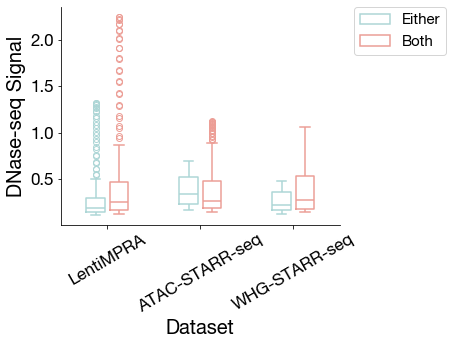

In [173]:
# DNase-seq 
plot_df = pd.concat([lentimpra_dnase_seq, atac_starr_dnase_seq, whg_starr_dnase_seq], ignore_index=True, axis=0)
plot_df.columns = ['signal', 'profile_type', 'call_type', 'dataset']

boxplot(data=plot_df,
    x_col='dataset',
    y_col='signal',
    hue_col='call_type',
    hue_order=['Either', 'Both'],
    x_order=['LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq'],
    xlabel='Dataset',
    ylabel='DNase-seq Signal',
    x_tick_labels=['LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq'],
    out_path='',
    rotation=30)


In [183]:
# Paired comparisons between lab-reported and uniform processed calls.
# For each DataFrame (representing a profile for a specific dataset and signal type),
# we perform a Mann-Whitney U test comparing the signal values between the two groups:
#  - "Lab-reported" (original calls)
#  - "Uniform Processed" (processed calls)
#
# We assume that the data column containing the mean signal profiles is column 0.
# The 'alternative' parameter is set to 'less', testing whether the values in the lab-reported group
# are statistically lower than those in the uniform processed group.

for data in [lentimpra_atac_seq, atac_starr_atac_seq, whg_starr_atac_seq]:
    # Separate the data into two groups based on the 'call_type' column.
    both = data[data['call_type'] == 'Both']
    either = data[data['call_type'] == 'Either']
    
    # Retrieve the dataset name from the 'dataset' column (assumes all rows have the same dataset value).
    dataset = data['dataset'].tolist()[0]
    print("Dataset:", dataset)
    
    # Retrieve the profile type (e.g., DNase-seq) from the 'profile_type' column.
    profile_type = data['profile_type'].tolist()[0]
    print("Profile type:", profile_type)
    
    # Perform the Mann-Whitney U test on the mean signal values.
    # We assume that the signal values are stored in column 0 of the DataFrame.
    test_statistic, p_value = scipy.stats.mannwhitneyu(
        either[0].values, 
        both[0].values, 
        alternative='less'
    )
    print("Mann-Whitney U test result (statistic, p-value):", test_statistic, p_value)
    print('-----')
    

Dataset: LentiMPRA
Profile type: ATAC-seq
Mann-Whitney U test result (statistic, p-value): 17394.0 0.01211023309568871
-----
Dataset: ATAC-STARR-seq
Profile type: ATAC-seq
Mann-Whitney U test result (statistic, p-value): 21444.0 0.894242954530206
-----
Dataset: WHG-STARR-seq
Profile type: ATAC-seq
Mann-Whitney U test result (statistic, p-value): 14758.0 2.8992204829534577e-06
-----


<ipython-input-133-bee54acd818d>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=rotation, fontsize=17)
<ipython-input-133-bee54acd818d>:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks, fontsize=17)


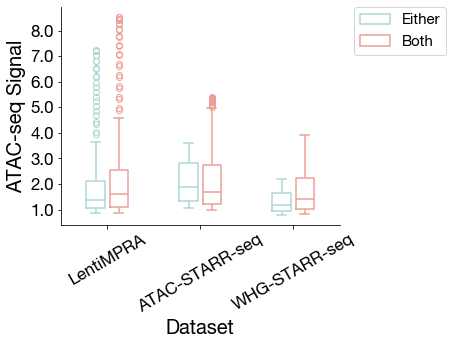

In [184]:
# ATAC-seq
plot_df = pd.concat([lentimpra_atac_seq, atac_starr_atac_seq, whg_starr_atac_seq], ignore_index=True, axis=0)
plot_df.columns = ['signal', 'profile_type', 'call_type', 'dataset']

boxplot(data=plot_df,
    x_col='dataset',
    y_col='signal',
    hue_col='call_type',
    hue_order=['Either', 'Both'],
    x_order=['LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq'],
    xlabel='Dataset',
    ylabel='ATAC-seq Signal',
    x_tick_labels=['LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq'],
    out_path='',
    rotation=30)


## Histone

In [140]:

# Histone: H3K4me3, H3K27ac
histone_root = os.path.join(project_root, 'data', 'output', 'computeMatrix', 
                                'original_vs_processed', 'matrix_Histone')


In [141]:
# Histone mean profile computation for multiple datasets.
# The function `process_matrix_file` reads a computeMatrix .gz file, parses its metadata to obtain
# sample boundaries (e.g., [0, 200, 400]) and group boundaries, and then computes the mean signal profiles
# for two groups (e.g., Lab-reported and Uniform Processed). It returns two DataFrames:
#   - One for H3K4me3 (sample 1)
#   - One for H3K27ac (sample 2)
# The 'offset' parameter indicates the number of non-signal columns at the start of each row.

# ------------------------------
# Process TilingMPRA dataset
# ------------------------------
# Build the data file path for TilingMPRA using the open_region_root directory.
data_path = os.path.join(histone_root, 'tilingmpra.gz')
# Specify the dataset name.
dataset = 'TilingMPRA'
# Call process_matrix_file to extract mean profiles.
# The function returns two DataFrames: one for DNase-seq and one for ATAC-seq.
tilingmpra_h3k4me3_seq, tilingmpra_h3k27ac_seq = process_matrix_file(data_path, ['Lab-reported', 'Uniform Processed'], dataset, offset=6)

# ------------------------------
# Process LentiMPRA dataset
# ------------------------------
# Build the data file path for LentiMPRA.
data_path = os.path.join(histone_root, 'lentimpra.gz')
# Set the dataset name.
dataset = 'LentiMPRA'
# Extract the DNase-seq and ATAC-seq mean profiles.
lentimpra_h3k4me3_seq, lentimpra_h3k27ac_seq = process_matrix_file(data_path, ['Lab-reported', 'Uniform Processed'], dataset, offset=6)

# ------------------------------
# Process ATAC-STARR-seq dataset
# ------------------------------
# Build the data file path for ATAC-STARR-seq.
data_path = os.path.join(histone_root, 'atac_starr.gz')
# Set the dataset name.
dataset = 'ATAC-STARR-seq'
# Extract the DNase-seq and ATAC-seq mean profiles.
atac_starr_h3k4me3_seq, atac_starr_h3k27ac_seq = process_matrix_file(data_path, ['Lab-reported', 'Uniform Processed'], dataset, offset=6)

# ------------------------------
# Process WHG-STARR-seq dataset
# ------------------------------
# Build the data file path for WHG-STARR-seq.
data_path = os.path.join(histone_root, 'whg_starr.gz')
# Set the dataset name.
dataset = 'WHG-STARR-seq'
# Extract the DNase-seq and ATAC-seq mean profiles.
whg_starr_h3k4me3_seq, whg_starr_h3k27ac_seq = process_matrix_file(data_path, ['Lab-reported', 'Uniform Processed'], dataset, offset=6)


<ipython-input-84-e64b57c15db3>:63: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t', skiprows=1, header=None)
<ipython-input-84-e64b57c15db3>:63: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t', skiprows=1, header=None)


In [143]:
# Paired comparisons between lab-reported and uniform processed calls.
# For each DataFrame (representing a profile for a specific dataset and signal type),
# we perform a Mann-Whitney U test comparing the signal values between the two groups:
#  - "Lab-reported" (original calls)
#  - "Uniform Processed" (processed calls)
#
# We assume that the data column containing the mean signal profiles is column 0.
# The 'alternative' parameter is set to 'less', testing whether the values in the lab-reported group
# are statistically lower than those in the uniform processed group.

for data in [tilingmpra_h3k4me3_seq, lentimpra_h3k4me3_seq, atac_starr_h3k4me3_seq, whg_starr_h3k4me3_seq]:
    # Separate the data into two groups based on the 'call_type' column.
    lab_reported = data[data['call_type'] == 'Lab-reported']
    uniform_processed = data[data['call_type'] == 'Uniform Processed']
    
    # Retrieve the dataset name from the 'dataset' column (assumes all rows have the same dataset value).
    dataset = data['dataset'].tolist()[0]
    print("Dataset:", dataset)
    
    # Retrieve the profile type (e.g., DNase-seq) from the 'profile_type' column.
    profile_type = data['profile_type'].tolist()[0]
    print("Profile type:", profile_type)
    
    # Perform the Mann-Whitney U test on the mean signal values.
    # We assume that the signal values are stored in column 0 of the DataFrame.
    test_statistic, p_value = scipy.stats.mannwhitneyu(
        lab_reported[0].values, 
        uniform_processed[0].values, 
        alternative='less'
    )
    print("Mann-Whitney U test result (statistic, p-value):", test_statistic, p_value)
    print('-----')
    

Dataset: TilingMPRA
Profile type: H3K4me3
Mann-Whitney U test result (statistic, p-value): 0.0 2.4154281951986995e-67
-----
Dataset: LentiMPRA
Profile type: H3K4me3
Mann-Whitney U test result (statistic, p-value): 3917.0 2.7356932021834577e-44
-----
Dataset: ATAC-STARR-seq
Profile type: H3K4me3
Mann-Whitney U test result (statistic, p-value): 8599.0 3.077715781514708e-23
-----
Dataset: WHG-STARR-seq
Profile type: H3K4me3
Mann-Whitney U test result (statistic, p-value): 0.0 2.4154281951986995e-67
-----


<ipython-input-133-bee54acd818d>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=rotation, fontsize=17)
<ipython-input-133-bee54acd818d>:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks, fontsize=17)


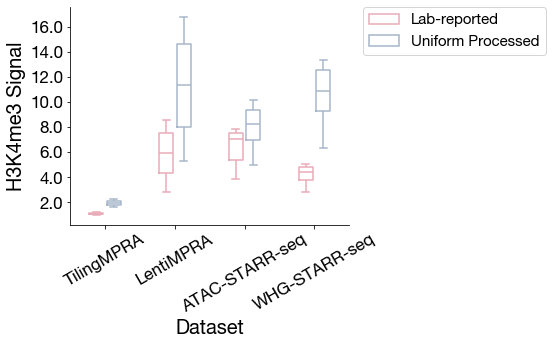

In [144]:
# H3K4me3 
plot_df = pd.concat([tilingmpra_h3k4me3_seq, lentimpra_h3k4me3_seq, atac_starr_h3k4me3_seq, whg_starr_h3k4me3_seq], ignore_index=True, axis=0)
plot_df.columns = ['signal', 'profile_type', 'call_type', 'dataset']

boxplot(data=plot_df,
    x_col='dataset',
    y_col='signal',
    hue_col='call_type',
    hue_order=['Lab-reported', 'Uniform Processed'],
    x_order=['TilingMPRA', 'LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq'],
    xlabel='Dataset',
    ylabel='H3K4me3 Signal',
    x_tick_labels=['TilingMPRA', 'LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq'],
    out_path='',
    rotation=30)


In [145]:
# Paired comparisons between lab-reported and uniform processed calls.
# For each DataFrame (representing a profile for a specific dataset and signal type),
# we perform a Mann-Whitney U test comparing the signal values between the two groups:
#  - "Lab-reported" (original calls)
#  - "Uniform Processed" (processed calls)
#
# We assume that the data column containing the mean signal profiles is column 0.
# The 'alternative' parameter is set to 'less', testing whether the values in the lab-reported group
# are statistically lower than those in the uniform processed group.

for data in [tilingmpra_h3k27ac_seq, lentimpra_h3k27ac_seq, atac_starr_h3k27ac_seq, whg_starr_h3k27ac_seq]:
    # Separate the data into two groups based on the 'call_type' column.
    lab_reported = data[data['call_type'] == 'Lab-reported']
    uniform_processed = data[data['call_type'] == 'Uniform Processed']
    
    # Retrieve the dataset name from the 'dataset' column (assumes all rows have the same dataset value).
    dataset = data['dataset'].tolist()[0]
    print("Dataset:", dataset)
    
    # Retrieve the profile type (e.g., DNase-seq) from the 'profile_type' column.
    profile_type = data['profile_type'].tolist()[0]
    print("Profile type:", profile_type)
    
    # Perform the Mann-Whitney U test on the mean signal values.
    # We assume that the signal values are stored in column 0 of the DataFrame.
    test_statistic, p_value = scipy.stats.mannwhitneyu(
        lab_reported[0].values, 
        uniform_processed[0].values, 
        alternative='less'
    )
    print("Mann-Whitney U test result (statistic, p-value):", test_statistic, p_value)
    print('-----')
    

Dataset: TilingMPRA
Profile type: H3K27ac
Mann-Whitney U test result (statistic, p-value): 0.0 2.4154281951986995e-67
-----
Dataset: LentiMPRA
Profile type: H3K27ac
Mann-Whitney U test result (statistic, p-value): 8029.0 2.0105104083728246e-25
-----
Dataset: ATAC-STARR-seq
Profile type: H3K27ac
Mann-Whitney U test result (statistic, p-value): 6478.0 6.731356938142183e-32
-----
Dataset: WHG-STARR-seq
Profile type: H3K27ac
Mann-Whitney U test result (statistic, p-value): 0.0 2.4154281951986995e-67
-----


<ipython-input-133-bee54acd818d>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=rotation, fontsize=17)
<ipython-input-133-bee54acd818d>:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks, fontsize=17)


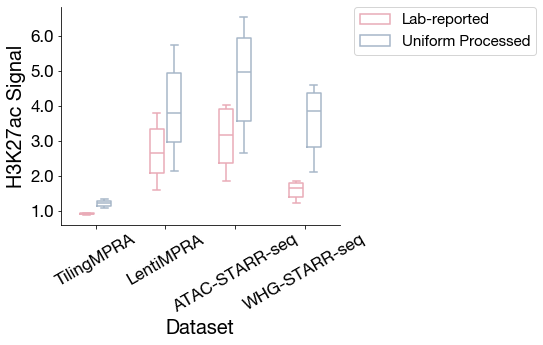

In [146]:
# ATAC-seq
plot_df = pd.concat([tilingmpra_h3k27ac_seq, lentimpra_h3k27ac_seq, atac_starr_h3k27ac_seq, whg_starr_h3k27ac_seq], ignore_index=True, axis=0)
plot_df.columns = ['signal', 'profile_type', 'call_type', 'dataset']

boxplot(data=plot_df,
    x_col='dataset',
    y_col='signal',
    hue_col='call_type',
    hue_order=['Lab-reported', 'Uniform Processed'],
    x_order=['TilingMPRA', 'LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq'],
    xlabel='Dataset',
    ylabel='H3K27ac Signal',
    x_tick_labels=['TilingMPRA', 'LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq'],
    out_path='',
    rotation=30)
